# Celery is used to schedule the computation. A sample example to tuning the hyperparameters of Prophet classifier is shown as usecase.

In [1]:
from mango.tuner import Tuner

In [2]:
from mango.domain.distribution import loguniform

param_dict = {"changepoint_prior_scale": loguniform(-3, 1),
              'seasonality_prior_scale' : loguniform(-1, 2)
             }

# userObjective on Celery

In [4]:
from mango.examples.classifiers.CeleryTasks import run_prophet



iteration_count = 1

def objective_Prophet(args_list):
    global iteration_count
    
    print('iteration_count:',iteration_count)
    
    iteration_count = iteration_count+1
    process_queue =[]
    
    for hyper_par in args_list:
        process = run_prophet.delay(hyper_par)
        process_queue.append(process)
    
    results = []
    for process in process_queue:
        result = process.get(timeout=100)
        results.append(result)
           
    return results

In [6]:
conf_Dict = dict()
conf_Dict['batch_size'] = 4
conf_Dict['num_iteration'] = 5

# Defining Tuner

In [7]:
tuner_user = Tuner(param_dict, objective_Prophet,conf_Dict)

In [8]:
tuner_user.getConf()

{'param_dict': {'changepoint_prior_scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a1703b3c8>,
  'seasonality_prior_scale': <scipy.stats._distn_infrastructure.rv_frozen at 0x1a1703b7f0>},
 'userObjective': <function __main__.objective_Prophet(args_list)>,
 'domain_size': 5000,
 'initial_random': 1,
 'num_iteration': 5,
 'objective': 'maximize',
 'batch_size': 4}

In [9]:
results = tuner_user.maximize()

iteration_count: 1
iteration_count: 2
iteration_count: 3
iteration_count: 4
iteration_count: 5
iteration_count: 6


# Inspect the results

In [10]:
print('best hyper parameters:',results['best_params'])
print('best objective:',results['best_objective'])

best hyper parameters: {'changepoint_prior_scale': 0.0042294922521082705, 'seasonality_prior_scale': 3.957068122364058}
best objective: -9.98624125085345


In [11]:
print('Sample hyper parameters tried:',len(results['params_tried']))
print(results['params_tried'][:2])

Sample hyper parameters tried: 21
[{'changepoint_prior_scale': 0.007171775499017729, 'seasonality_prior_scale': 0.6567066874502123}, {'changepoint_prior_scale': 0.007205258082367048, 'seasonality_prior_scale': 9.996656973924633}]


In [12]:
print('Sample objective values',len(results['objective_values']))
print(results['objective_values'][:5])

Sample objective values 21
[-10.019531079190951, -10.024258744254709, -10.022958312583524, -10.020957323385364, -9.98624125085345]


# Plotting the actual variation in objective values of the tried results

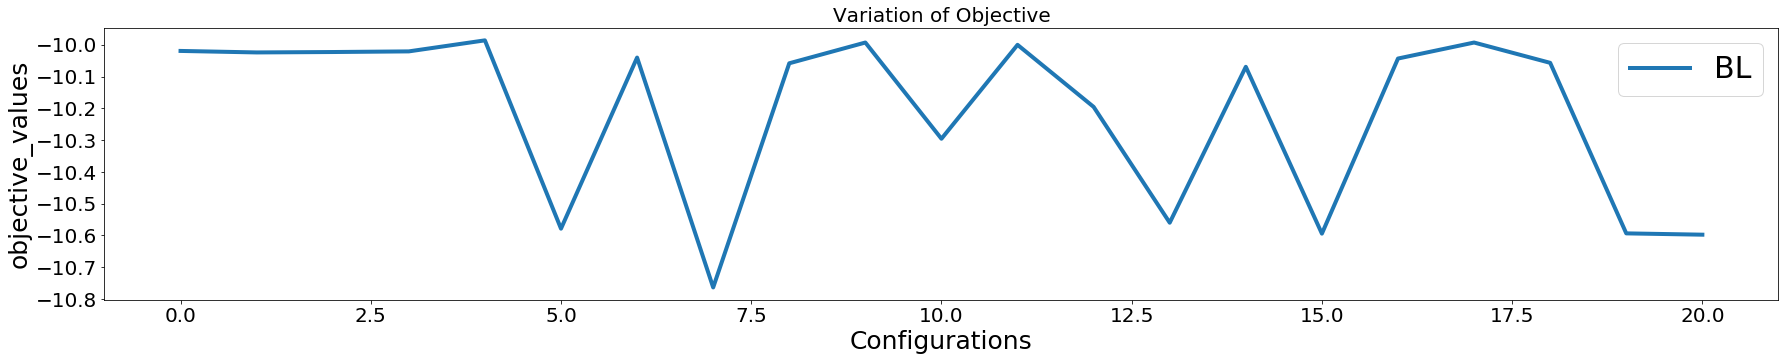

In [13]:
Size = 201 

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Variation of Objective',fontsize=20)
plt.plot(results['objective_values'][:Size],lw=4,label='BL')
plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# Plotting the variation of Max objective values of the tried results

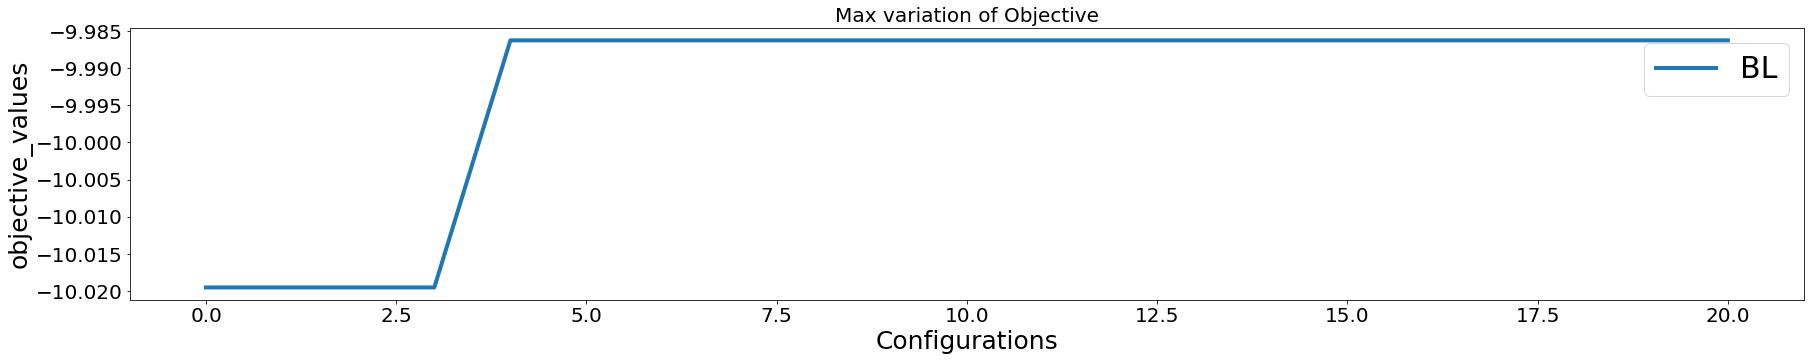

In [14]:
Size = 201 

import numpy as np

results_obj = np.array(results['objective_values'])

y_max=[]
for i in range(results_obj.shape[0]):
    y_max.append(np.max(results_obj[:i+1]))

from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,5))
plt.title('Max variation of Objective',fontsize=20)
plt.plot(y_max[:Size],lw=4,label='BL')
plt.xlabel('Configurations', fontsize=25)
plt.ylabel('objective_values',fontsize=25)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(prop={'size': 30})
plt.show()

# See the Result

In [15]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(results)

{   'best_objective': -9.98624125085345,
    'best_params': {   'changepoint_prior_scale': 0.0042294922521082705,
                       'seasonality_prior_scale': 3.957068122364058},
    'objective_values': [   -10.019531079190951,
                            -10.024258744254709,
                            -10.022958312583524,
                            -10.020957323385364,
                            -9.98624125085345,
                            -10.578828346854804,
                            -10.040424983212471,
                            -10.7638129741824,
                            -10.058406177114986,
                            -9.993059432906612,
                            -10.295900729131912,
                            -10.000346635466068,
                            -10.195629330143529,
                            -10.560063286831268,
                            -10.069513770186175,
                            -10.59446574869579,
                            -10.043457

#  See the learned classifier result on the test data

In [16]:
from classifiers.prophet import Prophet
from classifiers.xgboosttree import Xgboosttree
model = Xgboosttree()

import os
data_path = os.path.abspath('.')+'/classifiers/data/'

X_train, y_train =model.load_train_dataset(data_path+"PJME/train_data")
X_test, y_test = model.load_train_dataset(data_path+"PJME/test_data")
X_validate, y_validate = model.load_train_dataset(data_path+"PJME/validate_data")



model = Prophet(**results['best_params'])
model.fit(X_train, y_train.ravel())
y_pred = model.predict(X_test) 

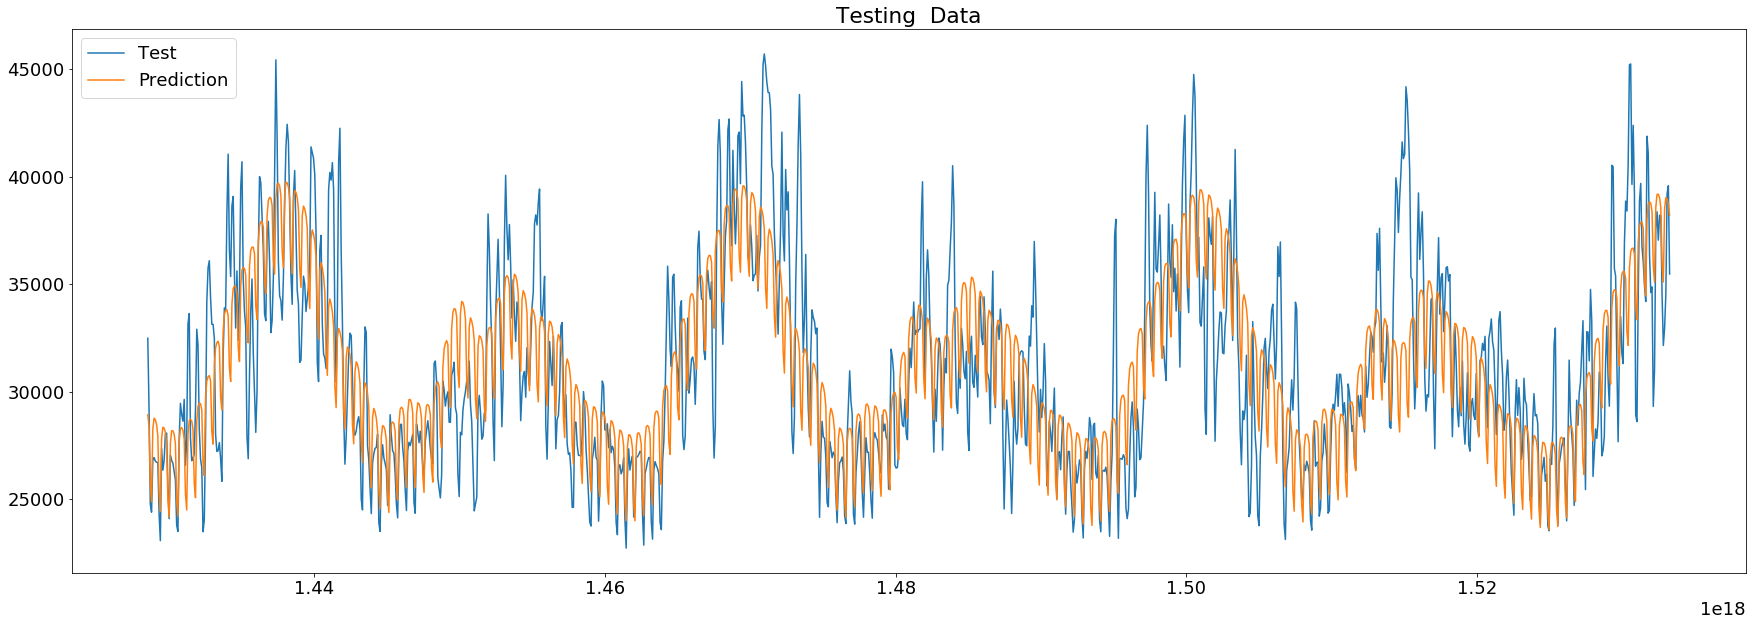

In [17]:
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})
plt.plot(X_test,y_test,label='Test')
plt.plot(X_test,y_pred,label='Prediction')
plt.title('Testing  Data')
plt.legend()
plt.show()

# All the Data

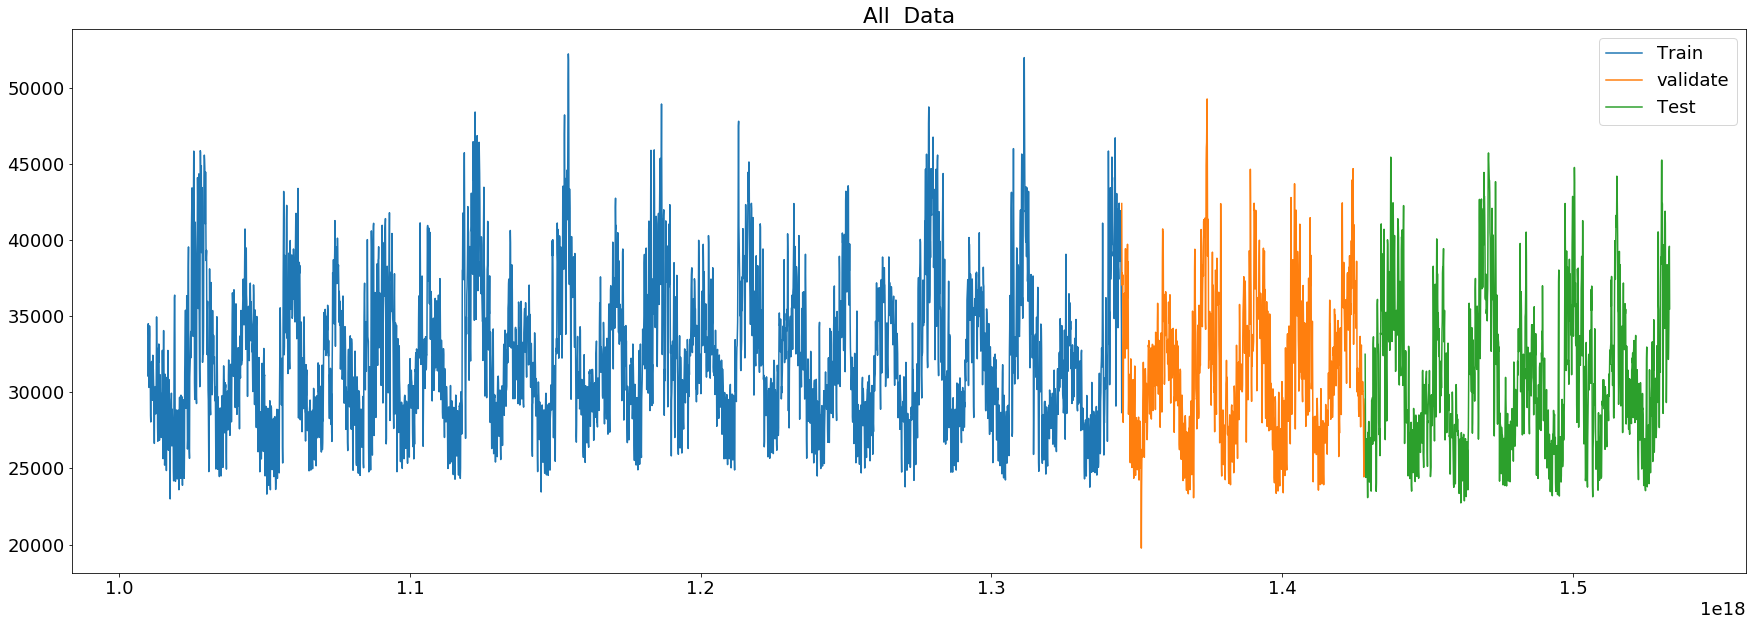

In [18]:
from classifiers.xgboosttree import Xgboosttree

model = Xgboosttree()

import os
data_path = os.path.abspath('.')+'/classifiers/data/'

X_train, y_train =model.load_train_dataset(data_path+"PJME/train_data")
X_test, y_test = model.load_train_dataset(data_path+"PJME/test_data")
X_validate, y_validate = model.load_train_dataset(data_path+"PJME/validate_data")



from matplotlib import pyplot as plt
fig = plt.figure(figsize=(30,10))
plt.rcParams.update({'font.size': 18})
plt.plot(X_train,y_train,label='Train')
plt.plot(X_validate,y_validate,label='validate')
plt.plot(X_test,y_test,label='Test')
plt.title('All  Data')
plt.legend()
plt.show()

